In [3]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [4]:
file_path = 'train_set.xlsx'
data_train = pd.read_excel(file_path)

In [5]:
file_path = 'val_set.xlsx'
data_val = pd.read_excel(file_path)

In [6]:
file_path = 'test_set.xlsx'
data_test = pd.read_excel(file_path)

In [7]:
wave_test = data_test.iloc[:, 5:1029].values 
temperature_test = data_test['temperature,oc'].values
fre_test = data_test['frequency,Hz'].values
c_loss_test = data_test['core loss,w/m3'].values
material_test = data_test['material type'].values
wavetype_test = data_test['excitation waveform'].values

wave_val = data_val.iloc[:, 5:1029].values 
temperature_val = data_val['temperature,oc'].values
fre_val = data_val['frequency,Hz'].values
c_loss_val = data_val['core loss,w/m3'].values
material_val = data_val['material type'].values
wavetype_val = data_val['excitation waveform'].values

wave_train = data_train.iloc[:, 5:1029].values 
temperature_train = data_train['temperature,oc'].values
fre_train = data_train['frequency,Hz'].values
c_loss_train = data_train['core loss,w/m3'].values
material_train = data_train['material type'].values
wavetype_train = data_train['excitation waveform'].values

In [8]:
scaler = StandardScaler()
temperature_train_scaled = scaler.fit_transform(temperature_train.reshape(-1, 1))
fre_train_scaled = scaler.fit_transform(fre_train.reshape(-1, 1))
temperature_train = torch.tensor(temperature_train_scaled, dtype=torch.float32)
fre_train = torch.tensor(fre_train_scaled, dtype=torch.float32)
wave_train = torch.tensor(wave_train, dtype=torch.float32)
material_train = torch.tensor(material_train-1, dtype=torch.long)
wavetype_train = torch.tensor(wavetype_train-1, dtype=torch.long)
c_loss_train = torch.tensor(c_loss_train, dtype=torch.float32)

temperature_val_scaled = scaler.fit_transform(temperature_val.reshape(-1, 1))
fre_val_scaled = scaler.fit_transform(fre_val.reshape(-1, 1))
temperature_val = torch.tensor(temperature_val_scaled, dtype=torch.float32)
fre_val = torch.tensor(fre_val_scaled, dtype=torch.float32)
wave_val = torch.tensor(wave_val, dtype=torch.float32)
material_val = torch.tensor(material_val-1, dtype=torch.long)
wavetype_val = torch.tensor(wavetype_val-1, dtype=torch.long)
c_loss_val = torch.tensor(c_loss_val, dtype=torch.float32)

temperature_test_scaled = scaler.fit_transform(temperature_test.reshape(-1, 1))
fre_test_scaled = scaler.fit_transform(fre_test.reshape(-1, 1))
temperature_test = torch.tensor(temperature_test_scaled, dtype=torch.float32)
fre_test = torch.tensor(fre_test_scaled, dtype=torch.float32)
wave_test = torch.tensor(wave_test, dtype=torch.float32)
material_test = torch.tensor(material_test-1, dtype=torch.long)
wavetype_test = torch.tensor(wavetype_test-1, dtype=torch.long)
c_loss_test = torch.tensor(c_loss_test, dtype=torch.float32)

In [9]:
encoder = OneHotEncoder(sparse_output=False)  
encoded_material_train = encoder.fit_transform(material_train.reshape(-1, 1))
encoded_wavetype_train = encoder.fit_transform(wavetype_train.reshape(-1, 1))
encoded_material_val = encoder.fit_transform(material_val.reshape(-1, 1))
encoded_wavetype_val = encoder.fit_transform(wavetype_val.reshape(-1, 1))
encoded_material_test = encoder.fit_transform(material_test.reshape(-1, 1))
encoded_wavetype_test = encoder.fit_transform(wavetype_test.reshape(-1, 1))

In [10]:
features_train = np.concatenate((temperature_train.reshape(-1, 1), 
                                 fre_train.reshape(-1, 1), 
                                 encoded_material_train, 
                                 encoded_wavetype_train), axis=1)
features_val = np.concatenate((temperature_val.reshape(-1, 1), 
                               fre_val.reshape(-1, 1), 
                               encoded_material_val, 
                               encoded_wavetype_val), axis=1)
features_test = np.concatenate((temperature_test.reshape(-1, 1), 
                                fre_test.reshape(-1, 1), 
                                encoded_material_test, 
                                encoded_wavetype_test), axis=1)

In [11]:
train_tensor = torch.FloatTensor(features_train)
wave_train_tensor = torch.FloatTensor(wave_train).unsqueeze(1) 

val_tensor = torch.FloatTensor(features_val)
wave_val_tensor = torch.FloatTensor(wave_val).unsqueeze(1)

test_tensor = torch.FloatTensor(features_test)
wave_test_tensor = torch.FloatTensor(wave_test).unsqueeze(1)

y_train_tensor = torch.FloatTensor(c_loss_train).view(-1, 1)
y_val_tensor = torch.FloatTensor(c_loss_val).view(-1, 1)
y_test_tensor = torch.FloatTensor(c_loss_test).view(-1, 1)

In [12]:
class HybridModel(nn.Module):
    def __init__(self, input_size, wave_hidden_size, output_size=1):
        super(HybridModel, self).__init__()
        self.fc_discrete = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(p=0.5)
        )
        self.lstm = nn.LSTM(input_size=1024, hidden_size=wave_hidden_size, num_layers=2, batch_first=True)
        self.fc_final = nn.Sequential(
            nn.Linear(wave_hidden_size + 64, 128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, output_size)
        )

    def forward(self, x_discrete, x_wave):
        discrete_out = self.fc_discrete(x_discrete)
        lstm_out, _ = self.lstm(x_wave)  
        lstm_out = lstm_out[:, -1, :]  
        
        combined = torch.cat((discrete_out, lstm_out), dim=1)
        output = self.fc_final(combined)
        return output


In [13]:
input_size = features_train.shape[1]  
hidden_size = 128  
num_epochs = 10000

In [14]:
model = HybridModel(input_size, hidden_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
patience = 50

In [15]:
train_losses = []
val_losses = []
best_val_loss = float('inf')  
patience_counter = 0 

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    output = model(train_tensor, wave_train_tensor)
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    model.eval()
    with torch.no_grad():
        val_output = model(val_tensor, wave_val_tensor)
        val_loss = criterion(val_output, y_val_tensor)
        val_losses.append(val_loss.item())
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping triggered.")
        break  

Epoch [1/10000], Train Loss: 182428418048.0000, Val Loss: 202224058368.0000
Epoch [2/10000], Train Loss: 182428418048.0000, Val Loss: 202224025600.0000
Epoch [3/10000], Train Loss: 182428368896.0000, Val Loss: 202224009216.0000
Epoch [4/10000], Train Loss: 182428352512.0000, Val Loss: 202223960064.0000
Epoch [5/10000], Train Loss: 182428303360.0000, Val Loss: 202223943680.0000
Epoch [6/10000], Train Loss: 182428286976.0000, Val Loss: 202223894528.0000
Epoch [7/10000], Train Loss: 182428237824.0000, Val Loss: 202223861760.0000
Epoch [8/10000], Train Loss: 182428172288.0000, Val Loss: 202223779840.0000
Epoch [9/10000], Train Loss: 182428123136.0000, Val Loss: 202223681536.0000
Epoch [10/10000], Train Loss: 182428057600.0000, Val Loss: 202223583232.0000
Epoch [11/10000], Train Loss: 182427942912.0000, Val Loss: 202223468544.0000
Epoch [12/10000], Train Loss: 182427844608.0000, Val Loss: 202223337472.0000
Epoch [13/10000], Train Loss: 182427713536.0000, Val Loss: 202223190016.0000
Epoch [1

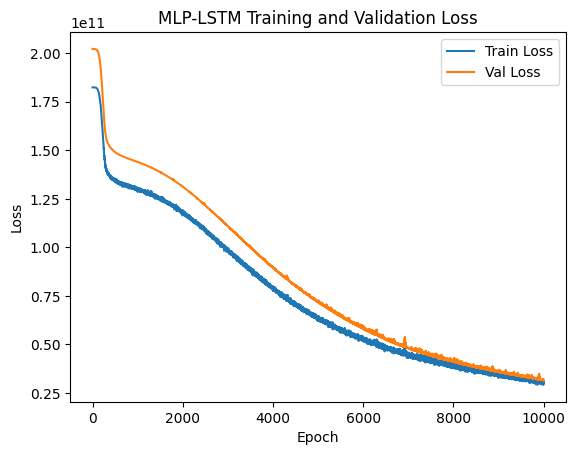

In [33]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('MLP-LSTM Training and Validation Loss')
plt.show()

In [49]:
model.eval()
with torch.no_grad():
    predictions = model(test_tensor, wave_test_tensor).numpy()

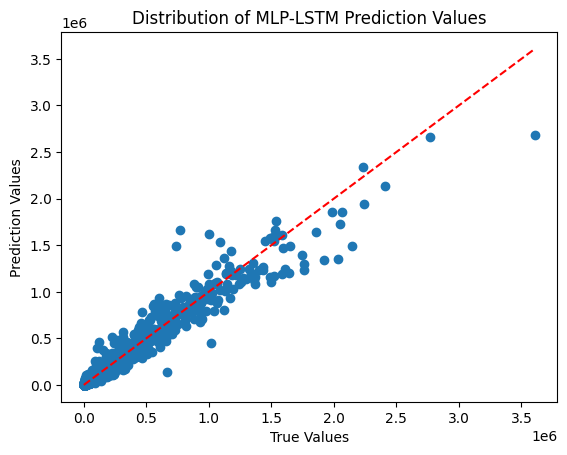

In [51]:
plt.scatter(y_test_tensor, predictions)
plt.xlabel('True Values')
plt.ylabel('Prediction Values')
plt.title('Distribution of MLP-LSTM Prediction Values')
plt.plot([y_test_tensor.min(), y_test_tensor.max()], [y_test_tensor.min(), y_test_tensor.max()], 'r--')
plt.show()

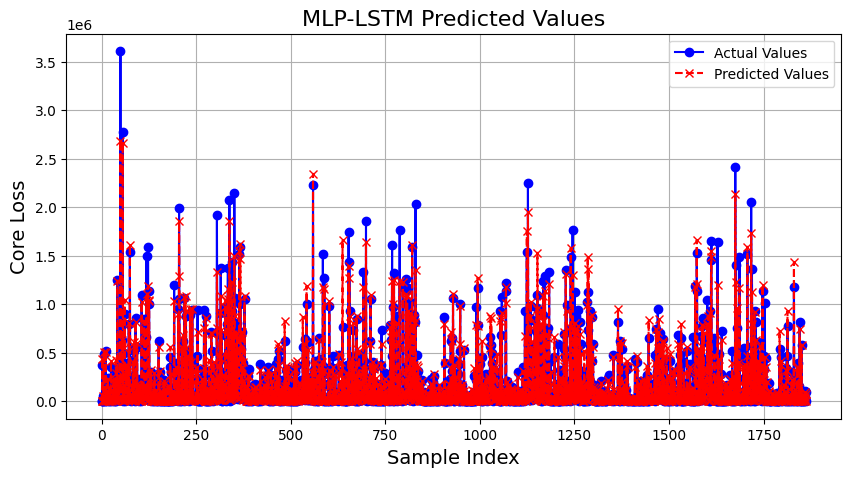

In [53]:
plt.figure(figsize=(10, 5))

plt.plot(y_test_tensor, label='Actual Values', marker='o', linestyle='-', color='blue')  
plt.plot(predictions, label='Predicted Values', marker='x', linestyle='--', color='red')  

# 添加标题和标签
plt.title('MLP-LSTM Predicted Values', fontsize=16)
plt.xlabel('Sample Index', fontsize=14)
plt.ylabel('Core Loss', fontsize=14)

# 显示图例
plt.legend()

# 显示图表
plt.grid(True)
plt.show()

In [55]:
mse = mean_squared_error(y_test_tensor, predictions)
r2 = r2_score(y_test_tensor, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_tensor, predictions)

print(f'Mean Squared Error (MSE): {mse}')
print(f'RMSE: {mse}')
print(f'R-squared (R²): {r2}')
print(f'MAE: {mae}')

Mean Squared Error (MSE): 6423268352.0
RMSE: 6423268352.0
R-squared (R²): 0.9452586770057678
MAE: 34748.19140625


In [57]:
predictions_np = np.array(predictions)
real_values_np = np.array(y_test_tensor)
mape = np.mean(np.abs((real_values_np-predictions_np) / real_values_np)) * 100
print(f'MAPE: {mape:.2f}%')

MAPE: 61.46%


In [298]:
torch.save(model, 'LSTM.pth')

In [47]:
model = torch.load('LSTM.pth')

C:\Users\12279\AppData\Local\Temp\ipykernel_2692\4122287743.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('LSTM.pth')
